# Scanner characterization EDA

# Imports

In [27]:
import re
import ruamel.yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("ticks",{'axes.grid' : True})

# Load data

In [28]:
BASE_PATH = Path("../scanner_params")
FILE_PATH = BASE_PATH.joinpath("scanners_params.csv").resolve()
SIMSET_MATERIALS = BASE_PATH.joinpath("simset_materials.csv").resolve()
STATS_PARAMS_FILE = BASE_PATH.joinpath("params_stats.csv")
DROP_COLS = [
    'TOF', 
    'PSF Correction', 
    'Missing parameters',
    'References', 
    'Notes',
    'reconstruction parameters',
    'YAML Configuration'
]
FIELDS = [
    'Scanner Name',
    'average_doi',
    'z_crystal_size',
    'crystal_thickness',
    'transaxial_crystal_size',
    'simset_material',
    'scanner_radius',
    'num_td_bins',
    'num_rings',
    'num_aa_bins',
    'min_energy_window',
    'max_energy_window',
    'energy_resolution',
    'coincidence_window',
    'axial_fov'
]
df_materials = pd.read_csv(SIMSET_MATERIALS)
df = pd.read_csv(FILE_PATH, usecols=FIELDS)
df = df.merge(df_materials, how="left", left_on="simset_material", right_on="Attenuation Index")
df["Material, Att. Idx."] = df["Material"].astype(str) + ', ' + df["Attenuation Index"].astype(str) 


# Númber of `s` bins (`num_td_bins`)

/tmp/ipykernel_7909/439982568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_td_bins[f"ratio_{i}"] = DIAMETER_FRACCTION * mul * df_td_bins["scanner_radius"] / df_td_bins["transaxial_crystal_size"]
/tmp/ipykernel_7909/439982568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_td_bins[f"ratio_{i}"] = DIAMETER_FRACCTION * mul * df_td_bins["scanner_radius"] / df_td_bins["transaxial_crystal_size"]


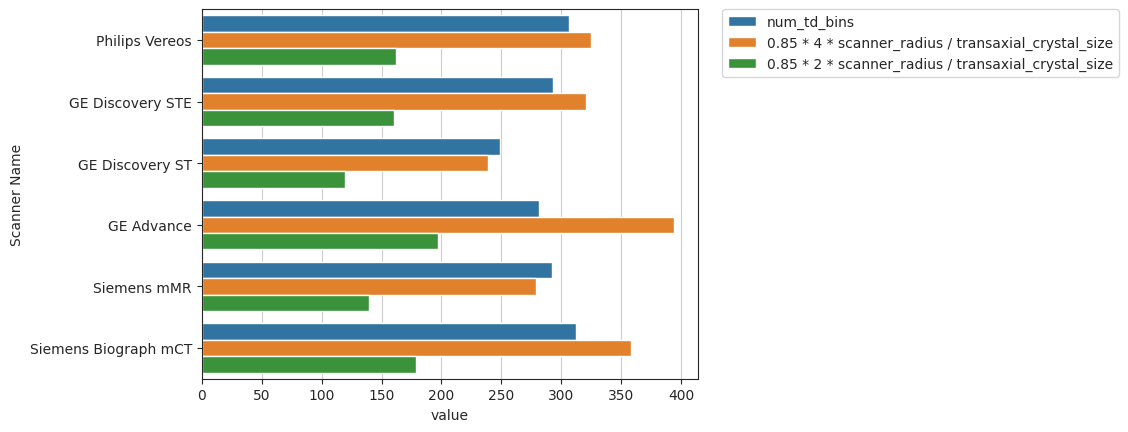

In [44]:
DIAMETER_FRACCTION = 0.85
MULT_SCANNER_RADIUS = [4, 2]

df_td_bins = df.dropna(subset=["num_td_bins"])

for i, mul in enumerate(MULT_SCANNER_RADIUS):
    df_td_bins[f"ratio_{i}"] = DIAMETER_FRACCTION * mul * df_td_bins["scanner_radius"] / df_td_bins["transaxial_crystal_size"]

g = df_td_bins\
    .pipe(pd.melt, id_vars=["Scanner Name"], value_vars=["num_td_bins", *[f"ratio_{i}" for i, _ in enumerate(MULT_SCANNER_RADIUS)]])\
    .replace({"variable": {
        (f"ratio_{i}"): (f"{DIAMETER_FRACCTION} * {mul} * scanner_radius / transaxial_crystal_size") for i, mul in enumerate(MULT_SCANNER_RADIUS)}})\
    .pipe(sns.barplot, x="value", y="Scanner Name", hue="variable")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Energy resolution

<AxesSubplot: xlabel='energy_resolution', ylabel='Scanner Name'>

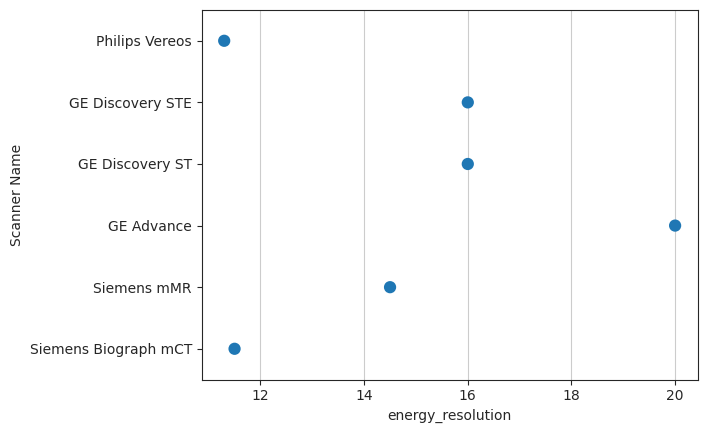

In [3]:
df.dropna().pipe(sns.pointplot, y="Scanner Name", x="energy_resolution", linestyles="")

<AxesSubplot: ylabel='energy_resolution'>

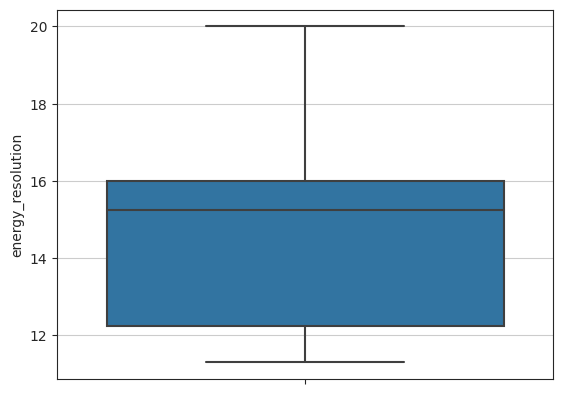

In [4]:
df.dropna().pipe(sns.boxplot, y="energy_resolution")

<AxesSubplot: xlabel='energy_resolution', ylabel='Count'>

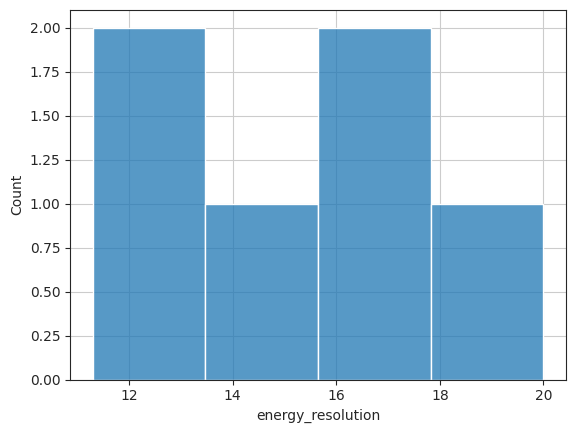

In [5]:
df.dropna().pipe(sns.histplot, x="energy_resolution")

## Material

<AxesSubplot: xlabel='Material, Att. Idx.', ylabel='P'>

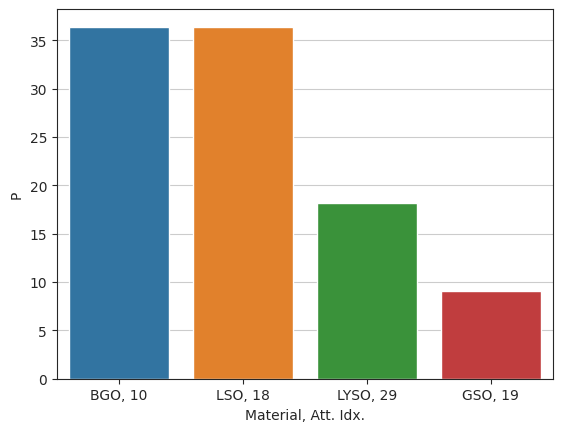

In [6]:
df_materials = df["Material, Att. Idx."]\
    .value_counts(normalize=True)\
    .rename_axis("Material, Att. Idx.")\
    .reset_index(name='P')
df_materials["P"] = (100 * df_materials["P"]).round(1)
df_materials.pipe(sns.barplot, x="Material, Att. Idx.", y ="P")


## Axial FOV

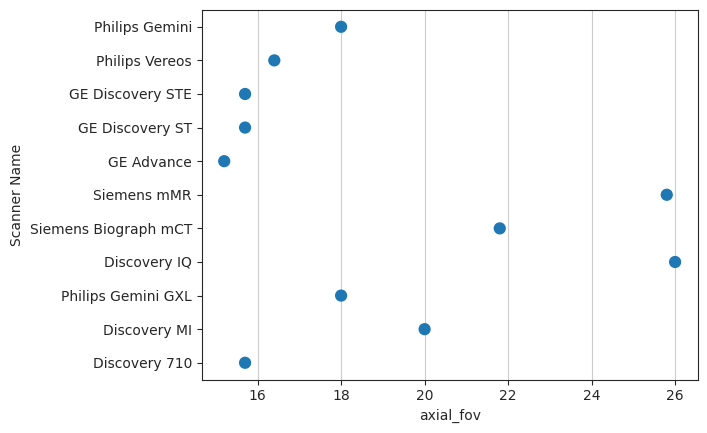

In [7]:
g = sns.pointplot(data=df, y="Scanner Name", x="axial_fov", linestyles="")

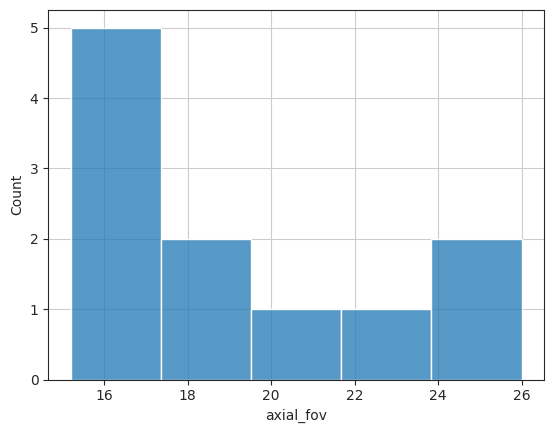

In [8]:
g = sns.histplot(data=df, x="axial_fov")

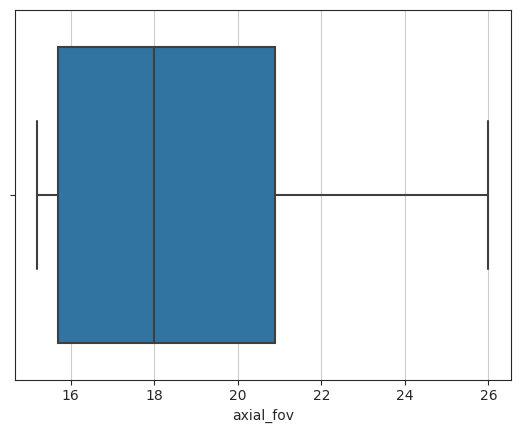

In [9]:
g = sns.boxplot(data=df, x="axial_fov")

## Cristal sizes

In [10]:
crystal_dims = [col for col in df.columns if bool(re.search(".*crystal.*", col))]
df[crystal_dims].describe().loc[["max", "mean", "min"], :].round(2)

,z_crystal_size,transaxial_crystal_size,crystal_thickness
max,0.81,0.63,3.00
mean,0.50,0.50,2.55
min,0.40,0.40,1.90


In [11]:
df_crystal = pd.melt(df, id_vars=["Scanner Name"], value_vars=crystal_dims).rename(columns={"variable": "Dim", "value": "Length"})

/home/yere/miniconda/envs/randfig/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


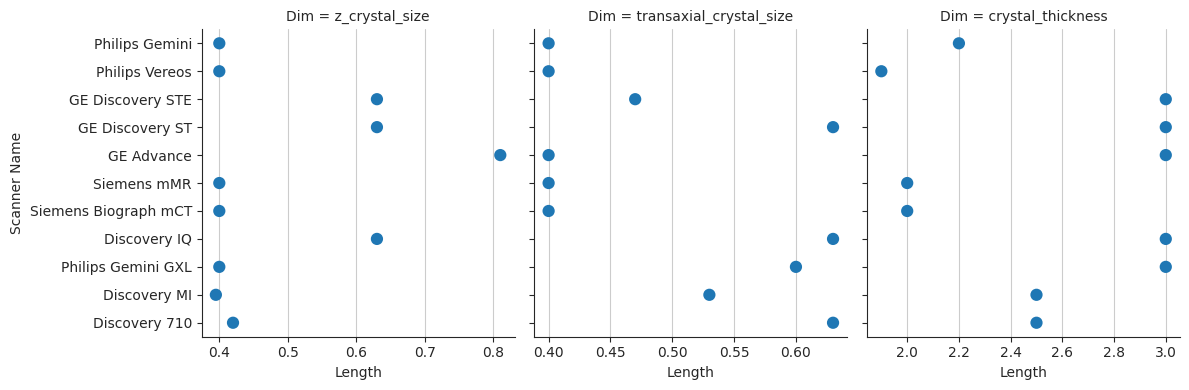

In [12]:
g = sns.FacetGrid(df_crystal, col="Dim", sharex=False, height=4, aspect=1)
g.map(sns.pointplot, "Length", "Scanner Name", linestyles="")

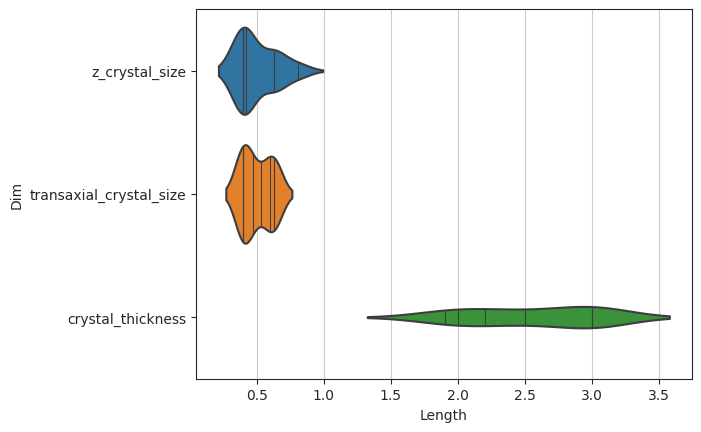

In [13]:
g = sns.violinplot(data=df_crystal, x="Length", y="Dim",  inner="stick", height=4, aspect=1)

## Save stats

In [14]:
min_max_params = [
    "energy_resolution", 
    "axial_fov",
    "scanner_radius",
    *crystal_dims
]

params = {}
for mvar in min_max_params:
    params[f"{mvar}_min"] = float(df[mvar].min())
    params[f"{mvar}_max"] = float(df[mvar].max())

materials = df_materials["Material, Att. Idx."].tolist()
proportions = df_materials["P"].tolist()

for mat, prop in zip(materials, proportions):
    element, att_idx = mat.split(", ")
    params[element] = att_idx
    params[f"p_{element}"] = float(prop)

In [16]:
with open(STATS_PARAMS_FILE, 'w') as pf:
    yaml = ruamel.yaml.YAML()
    yaml.indent(sequence=4, offset=2)   
    yaml.dump(params, pf)